In [ ]:
!pip install timm
!pip install lightning
!pip install astropy
import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


import sys
sys.path.append('/content/')

from dataloader_fits_cr import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

import scipy.stats as stats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/Dataset/aia_synoptic_copy_1.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 1024
num_epochs = 10
batch_size = 2
learning_rate = 0.001
dropout = 0.5
lstm_layers = 2

k_folds = 5

In [ ]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

In [ ]:
dataset = SunImageDataset(csv_file="/content/dataset_full_with_cr_4days.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size]
k_fold_2_indices = indices[fold_size:2*fold_size]
k_fold_3_indices = indices[2*fold_size:3*fold_size]
k_fold_4_indices = indices[3*fold_size:4*fold_size]
k_fold_5_indices = indices[4*fold_size:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]

# Get date list
kp_dates = pd.read_csv("/content/matched_kp_dates_full_with_cr_4days.csv")
kp_dates_list = kp_dates["date"].tolist()

1097
1097
1097
1097
1099


In [ ]:
# Get active indices
dataset_csv_file = pd.read_csv("/content/dataset_full_with_cr_4days.csv")
active_indices = []

for i in dataset_csv_file.index:
    if dataset_csv_file['Kp'][i] >= 3.667:
        active_indices.append(i)

active_dataloaders = []
for dataloader in dataloaders:
    active_dataloaders.append(list(set(dataloader) & set(active_indices)))

for dataloader in active_dataloaders:
    print(len(dataloader))

213
257
389
456
302


In [ ]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()

        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)

        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )

        self.lstm = nn.LSTM(hidden_size, hidden_size * 2, lstm_layers, batch_first=True)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            nn.Linear((hidden_size*2) + 2, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),

        )

    def forward(self, images, kp) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """

        batch_size = images.shape[0]

        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, 10, -1)
        # hidden_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # cell_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # image_features, _ = self.lstm(image_features, (hidden_states, cell_states))
        image_features, _ = self.lstm(image_features)
        image_features = image_features[:, -1, :]
        kp = kp.reshape(batch_size, 1)
        kp = kp.repeat(1, 2)
        image_features = torch.cat((image_features, kp), dim=1)
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 3.667:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 3.667:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1

    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):

    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if ((tp > 0 and tn > 0) or fp > 0) else 0
    return tss

def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1





In [ ]:
def train_model(fabric):
  print(fabric.device)
  total_avg_test_loss = 0
  total_rmse = 0
  total_mse = 0
  total_mae = 0
  total_r2 = 0
  total_r = 0
  total_tts = 0
  total_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0

  active_total_avg_test_loss = 0
  active_total_rmse = 0
  active_total_mse = 0
  active_total_mae = 0
  active_total_r2 = 0
  active_total_r = 0


  for i in range(k_folds):
      print(f'FOLD {i + 1}')
      print('--------------------------------')
      test_indices = dataloaders[i]
      active_test_indices = active_dataloaders[i]
      train_indices = []
      for j in range(k_folds):
          if j != i:
              train_indices += dataloaders[j]

      trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=20, prefetch_factor=6, pin_memory=True, worker_init_fn=lambda _: np.random.seed(42))
      testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      active_testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, active_test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      trainloader = fabric.setup_dataloaders(trainloader)
      testloader = fabric.setup_dataloaders(testloader)
      active_testloader = fabric.setup_dataloaders(active_testloader)


      # Reinitialize model
      model = GmiSwinTransformer(hidden_size=hidden_size)
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      model, optimizer = fabric.setup(model, optimizer)
      model.train()

      # Training the model
      n_total_steps = len(trainloader)
      avg_train_loss_over_epochs = []
      avg_val_loss_over_epochs = []

      for epoch in range(num_epochs):
          train_losses = []
          val_losses = []

          # Training loop
          model.train()
          for i, (images, labels, p_Kp) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
              # Move images and labels to device
              images = images.float()
              labels = labels.float()
              p_Kp = p_Kp.float()

              # Forward pass with autograd
              outputs = model(images, p_Kp).squeeze(1)
              loss = criterion(outputs, labels)
              # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

              # Backward pass and optimization
              optimizer.zero_grad()
              fabric.backward(loss)
              optimizer.step()
              # Store the loss
              train_losses.append(loss.item())

          # Store the average training loss for this epoch
          avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
          print("Average Training Loss: ", sum(train_losses) / len(train_losses))

          # Validation loop
          model.eval()
          with torch.no_grad():
              for images, labels, p_Kp in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                  images = images.float()
                  p_Kp = p_Kp.float()
                  # images = images.permute(1, 0, 2, 3, 4)
                  labels = labels.float()
                  outputs = model(images, p_Kp).squeeze(1)
                  loss = criterion(outputs, labels)
                  # print("Validation Loss: ", loss.item())
                  val_losses.append(loss.item())

          # Store the average validation loss for this epoch
          avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
          print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

      # Plot loss over epochs
      plt.figure()
      plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
      plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
      plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
      plt.xlabel('Epoch')
      plt.ylabel('Average Loss')
      plt.legend()
      plt.title('Training and Validation Loss Over Epochs')
      plt.show()

      test_losses = []
      all_labels = []
      all_outputs = []

      model.eval()

      print('--------------------------------')
      print('Test for Full set')
      print('--------------------------------')

  # Test for Full set
      with torch.no_grad():
          for images, labels, p_Kp in tqdm(testloader, desc="Testing Progress"):
              images = images.float()
              # images = images.permute(1, 0, 2, 3, 4)
              labels = labels.float()
              p_Kp = p_Kp.float()
              # print("Label: ", labels)
              outputs = model(images, p_Kp).squeeze(1)
              # print("Output: ", outputs)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      total_avg_test_loss += avg_test_loss
      total_rmse += rmse
      total_mse += mse
      total_mae += mae
      total_r2 += r2
      total_r += r
      total_tts += tts
      total_accuracy += accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1


      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')

      test_dates = list(kp_dates_list[i] for i in test_indices)
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
      plt.plot([0, len(test_dates)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')
      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Format x-axis with dates
      test_dates_sliced = test_dates[0:len(all_labels):20]
      plt.xticks(range(0, len(test_dates), 20), test_dates_sliced, rotation=30, ha='right')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Date', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)

      print('--------------------------------')
      print('Test for Active Periods')
      print('--------------------------------')

      test_losses = []
      all_labels = []
      all_outputs = []

  # Test for active periods
      with torch.no_grad():
          for images, labels, p_Kp in tqdm(active_testloader, desc="Testing Progress"):
              images = images.float()
              labels = labels.float()
              p_Kp = p_Kp.float()
              outputs = model(images, p_Kp).squeeze(1)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      active_total_avg_test_loss += avg_test_loss
      active_total_rmse += rmse
      active_total_mse += mse
      active_total_mae += mae
      active_total_r2 += r2
      active_total_r += r




      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with a window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')

      plt.plot([0, len(all_labels)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')

      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Sample Index', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)


  print('--------------------------------')
  print('Metrics for Full Set')
  print('--------------------------------')

  # Average metrics across all folds
  total_avg_test_loss /= k_folds
  total_rmse /= k_folds
  total_mse /= k_folds
  total_mae /= k_folds
  total_r2 /= k_folds
  total_r /= k_folds
  total_tts /= k_folds
  total_accuracy /= k_folds
  total_precision /= k_folds
  total_recall /= k_folds
  total_f1 /= k_folds

  print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
  print(f'Average RMSE across all folds: {total_rmse:.4f}')
  print(f'Average MSE across all folds: {total_mse:.4f}')
  print(f'Average MAE across all folds: {total_mae:.4f}')
  print(f'Average R² across all folds: {total_r2:.4f}')
  print(f'Average R across all folds: {total_r:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')
  print(f'Average True Skill Score across all folds: {total_tts:.4f}')
  print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
  print(f'Average Precision across all folds: {total_precision:.4f}')
  print(f'Average Recall across all folds: {total_recall:.4f}')
  print(f'Average F1 Score across all folds: {total_f1:.4f}')

  print('--------------------------------')
  print('Metrics for Active Periods')
  print('--------------------------------')
  # Average metrics across all folds
  active_total_avg_test_loss /= k_folds
  active_total_rmse /= k_folds
  active_total_mse /= k_folds
  active_total_mae /= k_folds
  active_total_r2 /= k_folds
  active_total_r /= k_folds

  print(f'Average active test loss across all folds: {active_total_avg_test_loss:.4f}')
  print(f'Average active RMSE across all folds: {active_total_rmse:.4f}')
  print(f'Average active MSE across all folds: {active_total_mse:.4f}')
  print(f'Average active MAE across all folds: {active_total_mae:.4f}')
  print(f'Average active R² across all folds: {active_total_r2:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')




INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0
FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.2471611209075837


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.550293190026794


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.5766504293358345


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.5868770271861579


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.2296416390002392


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.734740509709809


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.9352753214107705


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.5315837510568164


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7417949289126308


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6534151999815918


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5718692981395372


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6878747329556294


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4893824641540294


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7546091172470168


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.435173771584715


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6746271124011234


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3788029199827156


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6432324843748365


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3307896814569371


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.890396482267931


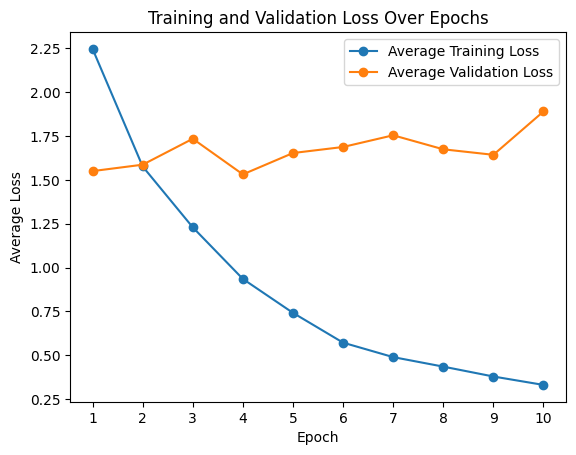

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.8904
RMSE: 1.3749
MSE: 1.8921
MAE: 1.0917
R²: -0.2084
R: 0.2648
True Skill Score: 0.0809
Accuracy: 0.7101
Precision: 0.2687
Recall: 0.2864
F1 Score: 0.2773


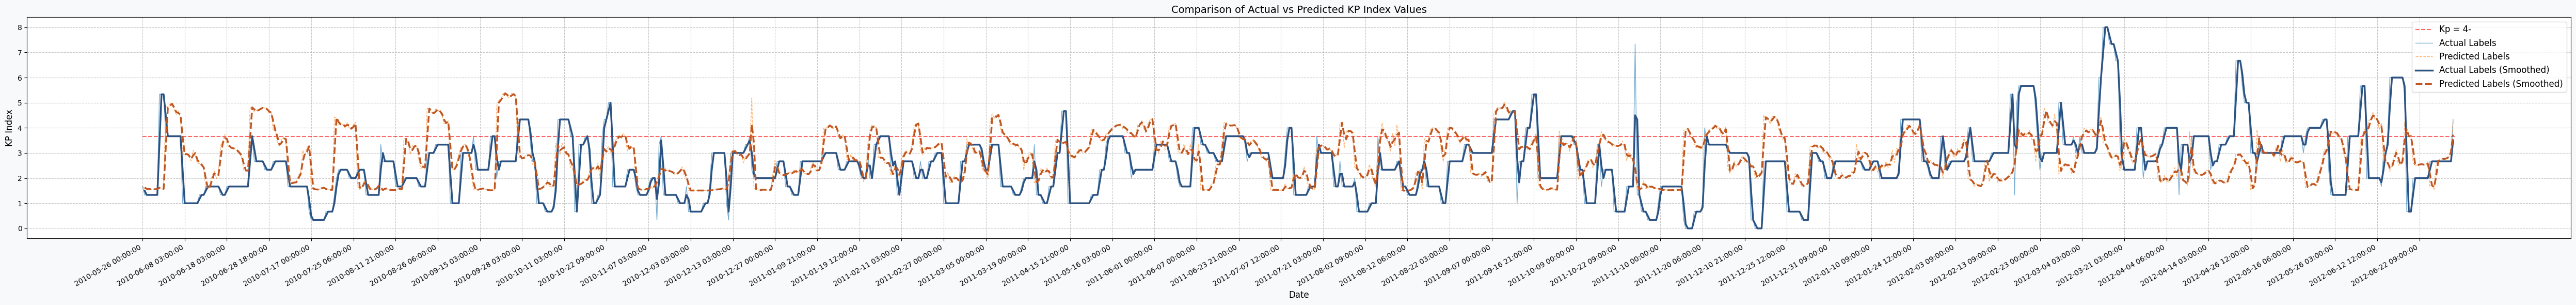

[np.float32(1.671875), np.float32(1.578125), np.float32(1.5703125), np.float32(1.5625), np.float32(1.5546875), np.float32(1.546875), np.float32(1.5703125), np.float32(1.5625), np.float32(1.65625), np.float32(1.5859375), np.float32(1.5546875), np.float32(4.875), np.float32(4.75), np.float32(5.0), np.float32(4.90625), np.float32(4.71875), np.float32(4.53125), np.float32(4.65625), np.float32(4.375), np.float32(2.921875), np.float32(2.953125), np.float32(2.96875), np.float32(2.84375), np.float32(2.6875), np.float32(3.109375), np.float32(2.890625), np.float32(2.578125), np.float32(2.59375), np.float32(2.484375), np.float32(2.375), np.float32(1.5859375), np.float32(1.5625), np.float32(1.765625), np.float32(2.09375), np.float32(2.28125), np.float32(1.9765625), np.float32(2.25), np.float32(3.296875), np.float32(3.453125), np.float32(3.734375), np.float32(3.390625), np.float32(3.21875), np.float32(3.203125), np.float32(3.171875), np.float32(3.15625), np.float32(3.046875), np.float32(2.96875), n

Testing Progress:   0%|          | 0/107 [00:00<?, ?it/s]

Average test loss: 3.4219
RMSE: 1.8498
MSE: 3.4338
MAE: 1.4983
R²: -2.5538
R: 0.0502
True Skill Score: 0.0000
Accuracy: 0.2864
Precision: 1.0000
Recall: 0.2864
F1 Score: 0.4453


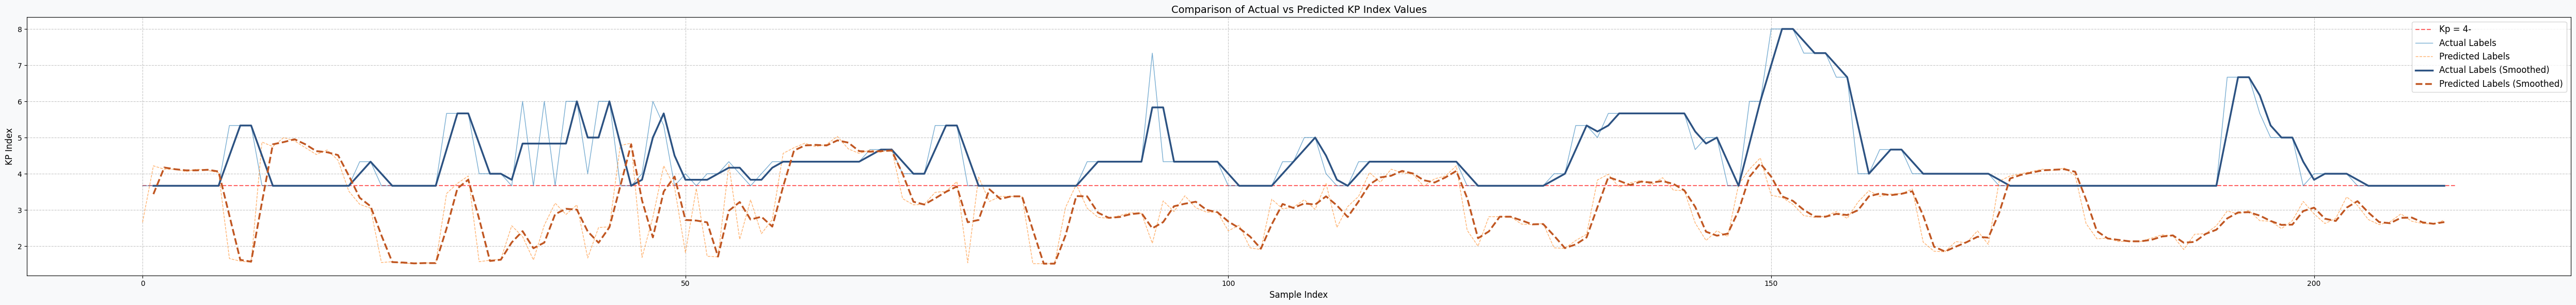

[np.float32(2.65625), np.float32(4.21875), np.float32(4.125), np.float32(4.125), np.float32(4.0625), np.float32(4.125), np.float32(4.09375), np.float32(4.03125), np.float32(1.65625), np.float32(1.5859375), np.float32(1.5546875), np.float32(4.875), np.float32(4.75), np.float32(5.0), np.float32(4.90625), np.float32(4.71875), np.float32(4.53125), np.float32(4.65625), np.float32(4.375), np.float32(3.515625), np.float32(3.15625), np.float32(3.046875), np.float32(1.546875), np.float32(1.5703125), np.float32(1.5234375), np.float32(1.5234375), np.float32(1.5390625), np.float32(1.5234375), np.float32(3.453125), np.float32(3.734375), np.float32(3.9375), np.float32(1.5703125), np.float32(1.609375), np.float32(1.640625), np.float32(2.5625), np.float32(2.265625), np.float32(1.6171875), np.float32(2.578125), np.float32(3.1875), np.float32(2.875), np.float32(3.140625), np.float32(1.671875), np.float32(2.515625), np.float32(2.53125), np.float32(4.78125), np.float32(4.84375), np.float32(1.6875), np.flo

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.269485541711193


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8122575806377963


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.5496095660505653


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.4585030091690576


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.1513757119058146


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8083291823948386


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.8580469301568024


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.5560914191093174


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6569657824582559


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.428442823067426


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5353604775163979


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8409445511836868


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.46809025940009363


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.150773365880318


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4167649268151483


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.350697480731827


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3670453796386021


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.5455495190504727


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3076946228091443


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.487051826839086


--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.4871
RMSE: 1.5770
MSE: 2.4892
MAE: 1.2810
R²: -0.5540
R: 0.1651
True Skill Score: 0.0717
Accuracy: 0.6682
Precision: 0.3550
Recall: 0.5097
F1 Score: 0.4185


[np.float32(4.875), np.float32(5.0625), np.float32(5.875), np.float32(5.875), np.float32(5.75), np.float32(5.46875), np.float32(5.375), np.float32(5.46875), np.float32(5.03125), np.float32(4.9375), np.float32(3.171875), np.float32(2.953125), np.float32(3.03125), np.float32(3.015625), np.float32(3.296875), np.float32(3.28125), np.float32(3.390625), np.float32(3.265625), np.float32(3.40625), np.float32(3.71875), np.float32(3.671875), np.float32(3.203125), np.float32(3.53125), np.float32(3.484375), np.float32(3.484375), np.float32(3.515625), np.float32(3.1875), np.float32(3.046875), np.float32(2.890625), np.float32(2.953125), np.float32(2.40625), np.float32(2.390625), np.float32(2.484375), np.float32(2.109375), np.float32(3.3125), np.float32(3.125), np.float32(2.9375), np.float32(2.9375), np.float32(2.84375), np.float32(2.890625), np.float32(2.9375), np.float32(2.5), np.float32(2.25), np.float32(2.171875), np.float32(1.9296875), np.float32(4.0), np.float32(4.21875), np.float32(4.34375), n

Testing Progress:   0%|          | 0/129 [00:00<?, ?it/s]

Average test loss: 1.7535
RMSE: 1.3242
MSE: 1.7603
MAE: 1.1097
R²: -2.0414
R: 0.0823
True Skill Score: 0.0000
Accuracy: 0.5097
Precision: 1.0000
Recall: 0.5097
F1 Score: 0.6753


[np.float32(4.875), np.float32(4.90625), np.float32(5.25), np.float32(5.375), np.float32(5.96875), np.float32(5.34375), np.float32(5.03125), np.float32(5.09375), np.float32(3.75), np.float32(3.765625), np.float32(3.71875), np.float32(3.703125), np.float32(3.640625), np.float32(4.71875), np.float32(4.5625), np.float32(4.625), np.float32(4.15625), np.float32(4.53125), np.float32(4.625), np.float32(4.40625), np.float32(4.875), np.float32(5.0625), np.float32(5.875), np.float32(5.875), np.float32(5.75), np.float32(5.46875), np.float32(5.375), np.float32(5.46875), np.float32(5.03125), np.float32(2.921875), np.float32(3.171875), np.float32(2.953125), np.float32(3.125), np.float32(3.09375), np.float32(3.15625), np.float32(2.96875), np.float32(2.984375), np.float32(3.03125), np.float32(3.3125), np.float32(3.71875), np.float32(3.671875), np.float32(3.203125), np.float32(3.53125), np.float32(3.125), np.float32(3.328125), np.float32(3.25), np.float32(3.1875), np.float32(3.265625), np.float32(3.078

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.095303890230092


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2904065118075003


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.5344548282120696


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7677086573346468


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.1505959580399963


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9724305144518373


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.863601744693337


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7050113730369651


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.658890569659153


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7400391709725525


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5531921969745542


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7958380951460677


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.448807776224647


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8125249769198089


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3814231420018046


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.757187985390266


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.32814730050150814


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.929082804672693


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3086582611088635


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1908665346923217


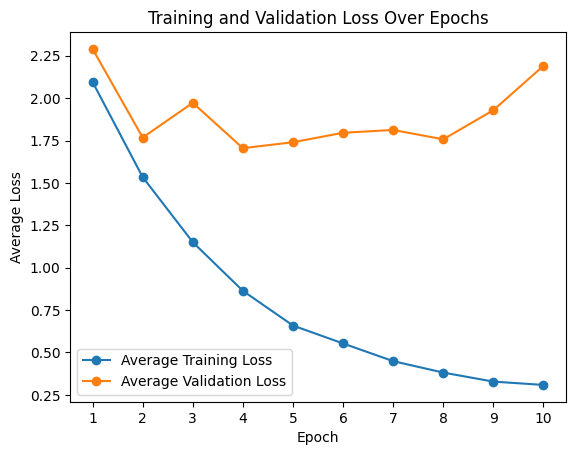

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.1909
RMSE: 1.4802
MSE: 2.1926
MAE: 1.1609
R²: -0.1846
R: 0.2735
True Skill Score: 0.5425
Accuracy: 0.6554
Precision: 0.5821
Recall: 0.1003
F1 Score: 0.1711


[np.float32(1.328125), np.float32(1.3203125), np.float32(1.3203125), np.float32(1.328125), np.float32(1.328125), np.float32(1.34375), np.float32(1.359375), np.float32(2.765625), np.float32(2.421875), np.float32(2.46875), np.float32(2.453125), np.float32(2.28125), np.float32(2.3125), np.float32(2.1875), np.float32(1.90625), np.float32(1.9375), np.float32(1.75), np.float32(2.046875), np.float32(2.078125), np.float32(1.9296875), np.float32(2.25), np.float32(2.234375), np.float32(1.9609375), np.float32(1.9921875), np.float32(1.90625), np.float32(2.0625), np.float32(2.0625), np.float32(2.21875), np.float32(2.0625), np.float32(2.015625), np.float32(1.3046875), np.float32(1.3125), np.float32(1.3125), np.float32(1.296875), np.float32(1.4375), np.float32(1.3828125), np.float32(1.4140625), np.float32(1.4765625), np.float32(2.078125), np.float32(1.921875), np.float32(1.6328125), np.float32(1.4375), np.float32(1.421875), np.float32(1.703125), np.float32(1.65625), np.float32(1.8984375), np.float32(

Testing Progress:   0%|          | 0/195 [00:00<?, ?it/s]

Average test loss: 4.3961
RMSE: 2.0967
MSE: 4.4028
MAE: 1.8264
R²: -3.3412
R: 0.2480
True Skill Score: 0.0000
Accuracy: 0.1003
Precision: 1.0000
Recall: 0.1003
F1 Score: 0.1822


[np.float32(2.421875), np.float32(2.46875), np.float32(2.453125), np.float32(2.28125), np.float32(2.3125), np.float32(2.1875), np.float32(1.90625), np.float32(1.9375), np.float32(1.75), np.float32(2.046875), np.float32(1.8046875), np.float32(1.7109375), np.float32(1.9765625), np.float32(2.390625), np.float32(2.890625), np.float32(2.359375), np.float32(2.796875), np.float32(2.734375), np.float32(3.0), np.float32(3.28125), np.float32(3.15625), np.float32(3.515625), np.float32(3.46875), np.float32(2.765625), np.float32(2.578125), np.float32(2.625), np.float32(2.90625), np.float32(2.71875), np.float32(2.15625), np.float32(2.21875), np.float32(1.96875), np.float32(1.3671875), np.float32(1.5859375), np.float32(1.6484375), np.float32(1.359375), np.float32(1.3984375), np.float32(1.3984375), np.float32(1.3203125), np.float32(1.4140625), np.float32(1.3828125), np.float32(1.265625), np.float32(1.2578125), np.float32(1.2578125), np.float32(1.2578125), np.float32(2.421875), np.float32(2.46875), np.

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.1848680883346754


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7467837240695376


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.5487780553655242


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7280526174256112


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.2239497450517134


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8484977650719496


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.9218654562148625


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8185211522201457


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7482817457369656


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6964421749587013


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5816981741594637


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8087834252349062


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4993555617565395


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.5925233082081156


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.44903970764993373


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.809001154889088


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3776080359766862


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0034911520097394


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.332734535501303


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7759026081137146


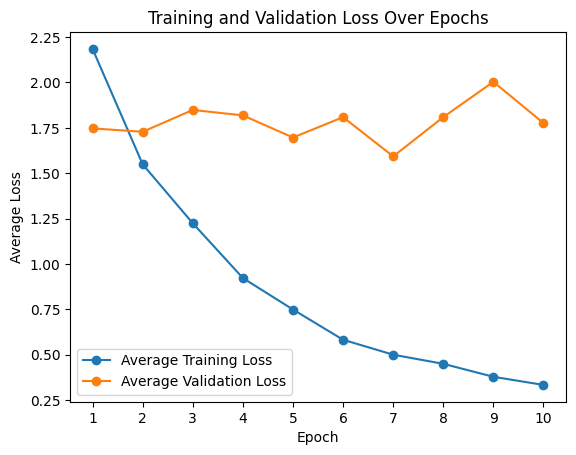

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.7759
RMSE: 1.3326
MSE: 1.7775
MAE: 1.0777
R²: -0.0396
R: 0.3639
True Skill Score: 0.2621
Accuracy: 0.6335
Precision: 0.5616
Recall: 0.5395
F1 Score: 0.5503


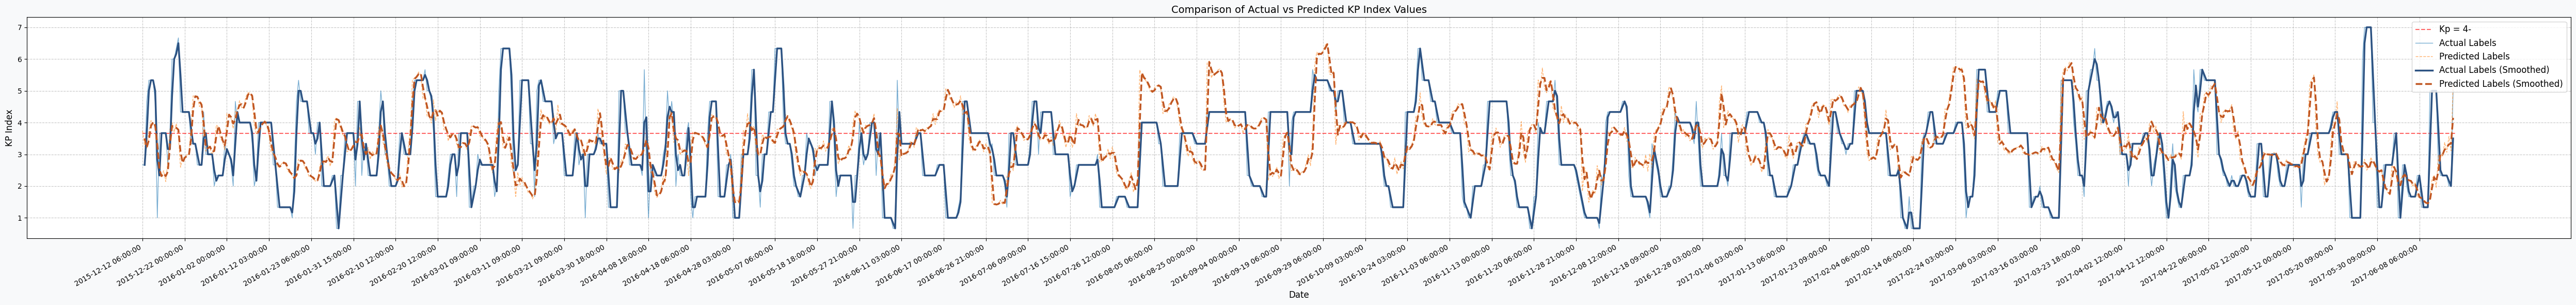

[np.float32(3.734375), np.float32(3.265625), np.float32(3.171875), np.float32(3.71875), np.float32(4.0625), np.float32(3.96875), np.float32(3.84375), np.float32(2.734375), np.float32(2.328125), np.float32(2.296875), np.float32(2.484375), np.float32(2.140625), np.float32(2.78125), np.float32(3.796875), np.float32(4.0), np.float32(3.703125), np.float32(3.96875), np.float32(3.578125), np.float32(2.59375), np.float32(2.875), np.float32(2.90625), np.float32(2.984375), np.float32(2.984375), np.float32(3.953125), np.float32(4.84375), np.float32(4.8125), np.float32(4.8125), np.float32(4.5), np.float32(4.625), np.float32(3.359375), np.float32(3.09375), np.float32(3.28125), np.float32(3.203125), np.float32(2.96875), np.float32(3.234375), np.float32(3.921875), np.float32(3.859375), np.float32(3.484375), np.float32(3.40625), np.float32(3.140625), np.float32(4.28125), np.float32(4.21875), np.float32(4.125), np.float32(3.8125), np.float32(4.34375), np.float32(4.40625), np.float32(4.6875), np.float32

Testing Progress:   0%|          | 0/228 [00:00<?, ?it/s]

Average test loss: 1.6160
RMSE: 1.2712
MSE: 1.6160
MAE: 0.9905
R²: -2.0191
R: 0.1587
True Skill Score: 0.0000
Accuracy: 0.5395
Precision: 1.0000
Recall: 0.5395
F1 Score: 0.7009


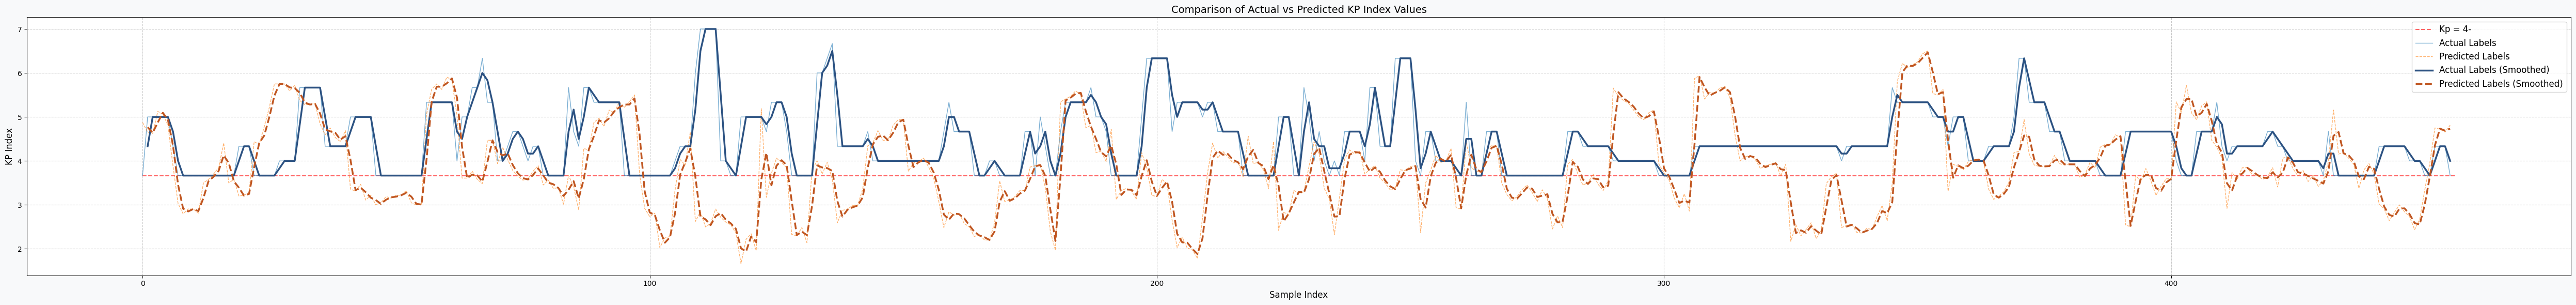

[np.float32(4.875), np.float32(4.65625), np.float32(4.625), np.float32(5.125), np.float32(5.0625), np.float32(4.8125), np.float32(3.890625), np.float32(3.03125), np.float32(2.796875), np.float32(2.90625), np.float32(2.90625), np.float32(2.8125), np.float32(3.5), np.float32(3.578125), np.float32(3.703125), np.float32(3.84375), np.float32(4.40625), np.float32(3.5), np.float32(3.578125), np.float32(3.203125), np.float32(3.21875), np.float32(3.28125), np.float32(4.4375), np.float32(4.375), np.float32(4.78125), np.float32(5.21875), np.float32(5.75), np.float32(5.75), np.float32(5.75), np.float32(5.59375), np.float32(5.71875), np.float32(5.375), np.float32(5.28125), np.float32(5.28125), np.float32(5.3125), np.float32(4.84375), np.float32(4.59375), np.float32(4.75), np.float32(4.53125), np.float32(4.4375), np.float32(4.6875), np.float32(3.359375), np.float32(3.3125), np.float32(3.46875), np.float32(3.109375), np.float32(3.21875), np.float32(3.0), np.float32(3.046875), np.float32(3.1875), np.f

Training Progress: Epoch: 1:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  2.1814823471496934


Validation Progress: Epoch: 1:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5952584425285221


Training Progress: Epoch: 2:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.5438377791143618


Validation Progress: Epoch: 2:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.7188998185189186


Training Progress: Epoch: 3:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.176614743823119


Validation Progress: Epoch: 3:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.4452934057330078


Training Progress: Epoch: 4:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.9155675140875558


Validation Progress: Epoch: 4:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.659103483739944


Training Progress: Epoch: 5:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.7073000076560996


Validation Progress: Epoch: 5:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5942174314694817


Training Progress: Epoch: 6:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.5846176097340284


Validation Progress: Epoch: 6:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5402213115534158


Training Progress: Epoch: 7:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.4873762769804228


Validation Progress: Epoch: 7:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.54875248858557


Training Progress: Epoch: 8:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.42157004669681364


Validation Progress: Epoch: 8:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5867796403127299


Training Progress: Epoch: 9:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.36995820351111414


Validation Progress: Epoch: 9:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5637946530600841


Training Progress: Epoch: 10:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.3056238619215514


Validation Progress: Epoch: 10:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.6432034907317574


--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/550 [00:00<?, ?it/s]

Average test loss: 1.6432
RMSE: 1.2819
MSE: 1.6446
MAE: 0.9807
R²: 0.0709
R: 0.4227
True Skill Score: 0.5433
Accuracy: 0.7352
Precision: 0.5797
Recall: 0.1325
F1 Score: 0.2156


[np.float32(3.671875), np.float32(4.3125), np.float32(4.40625), np.float32(3.75), np.float32(3.0), np.float32(2.625), np.float32(2.359375), np.float32(2.484375), np.float32(2.3125), np.float32(2.34375), np.float32(1.6875), np.float32(2.09375), np.float32(1.953125), np.float32(1.7578125), np.float32(1.984375), np.float32(2.25), np.float32(2.734375), np.float32(3.546875), np.float32(3.03125), np.float32(3.078125), np.float32(3.640625), np.float32(1.8828125), np.float32(2.53125), np.float32(2.203125), np.float32(1.6875), np.float32(2.28125), np.float32(2.171875), np.float32(2.296875), np.float32(2.828125), np.float32(2.796875), np.float32(2.84375), np.float32(2.90625), np.float32(1.7421875), np.float32(1.6953125), np.float32(1.453125), np.float32(1.5078125), np.float32(1.3359375), np.float32(1.34375), np.float32(1.3046875), np.float32(1.40625), np.float32(1.3359375), np.float32(2.296875), np.float32(1.9921875), np.float32(2.90625), np.float32(2.953125), np.float32(2.828125), np.float32(2.

Testing Progress:   0%|          | 0/151 [00:00<?, ?it/s]

Average test loss: 3.7684
RMSE: 1.9412
MSE: 3.7684
MAE: 1.6674
R²: -4.0381
R: 0.2110
True Skill Score: 0.0000
Accuracy: 0.1325
Precision: 1.0000
Recall: 0.1325
F1 Score: 0.2339


[np.float32(3.34375), np.float32(3.40625), np.float32(3.453125), np.float32(1.59375), np.float32(1.3515625), np.float32(1.828125), np.float32(1.734375), np.float32(1.4765625), np.float32(3.265625), np.float32(2.671875), np.float32(2.796875), np.float32(2.359375), np.float32(2.828125), np.float32(2.4375), np.float32(1.6171875), np.float32(1.4921875), np.float32(1.8671875), np.float32(1.8203125), np.float32(2.34375), np.float32(1.875), np.float32(1.3671875), np.float32(1.40625), np.float32(1.390625), np.float32(1.9453125), np.float32(1.453125), np.float32(1.53125), np.float32(1.484375), np.float32(2.125), np.float32(2.1875), np.float32(2.84375), np.float32(3.046875), np.float32(2.90625), np.float32(3.09375), np.float32(4.125), np.float32(2.71875), np.float32(3.359375), np.float32(3.390625), np.float32(3.71875), np.float32(4.0), np.float32(4.03125), np.float32(3.859375), np.float32(3.546875), np.float32(4.0), np.float32(3.96875), np.float32(3.59375), np.float32(3.453125), np.float32(3.234

In [ ]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch(train_model)


In [ ]:
# prompt: disconnect runtime
import time
time.sleep(5 * 60)
from google.colab import runtime
runtime.unassign()
